In [6]:
import pandas as pd
import numpy as np
from numpy import newaxis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import yfinance as yf
import datetime

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import r2_score
import pmdarima as pmd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px

## Language Processing

In [7]:
# df = pd.read_csv('data/us_financial_news_articles_2018.csv')[['published_date','source_name','title']]
# df[df.isnull().any(axis=1)]
# df_missing_percentage=df.isnull().sum()/df.shape[0] *100
# df=df.dropna()
# sid = SentimentIntensityAnalyzer()
# title_score = [sid.polarity_scores(sent) for sent in df.title]   
# df['compound'] = pd.DataFrame(title_score)['compound']
# df = df[['published_date', 'source_name', 'compound']]
# df['published_date'] = df['published_date'].str[:10]
# df['source_name'] = df['source_name'].str[:-4]
# df.to_csv('news_with_sentiment.csv')

In [8]:
start = datetime.datetime(2017, 12, 6)
end = datetime.datetime(2018, 6, 2)

df_index = pd.DataFrame()
tickers = {'^GSPC':'SP','^NDX':'NDX','^DJI':'DJI', '^RUT':'RUT'}
for tick in tickers.keys():
    tk = yf.Ticker(tick).history(start = start, end = end)['Close']
    df_index[tickers[tick]] = tk
    df_index[tickers[tick]+"_r"] = tk.pct_change()
df_index.index = df_index.index.date
df_index = df_index.dropna()

In [9]:
df = pd.read_csv("news_with_sentiment.csv",index_col=0)
df = df.groupby(['published_date', 'source_name']).mean()
df.reset_index(drop = False, inplace = True)
pivot_df = df.pivot_table(values='compound', index='published_date', columns='source_name', aggfunc='mean')
pivot_df.columns = [col + '_mean_compound' for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

pivot_df['published_date'] = pd.to_datetime(pivot_df['published_date'])
pivot_df = pivot_df.set_index('published_date')
 
merged_df = pd.merge(df_index, pivot_df, left_index=True, right_index = True, how='left')
merged_df = merged_df.fillna(0)
merged_df.head()

,SP,SP_r,NDX,NDX_r,DJI,DJI_r,RUT,RUT_r,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,wsj_mean_compound
2017-12-07,2636.979980,0.002932,6316.279785,0.003691,24211.480469,0.002923,1520.469971,0.007681,-0.1366,0.0000,0.0,0.296
2017-12-08,2651.500000,0.005506,6344.569824,0.004479,24329.160156,0.004860,1521.719971,0.000822,0.0000,-0.2423,0.0,0.000
2017-12-11,2659.989990,0.003202,6393.890137,0.007774,24386.029297,0.002337,1519.839966,-0.001235,0.0000,0.0000,0.0,0.000
2017-12-12,2664.110107,0.001549,6383.649902,-0.001602,24504.800781,0.004870,1516.119995,-0.002448,0.0000,0.0000,0.0,0.000
2017-12-13,2662.850098,-0.000473,6394.669922,0.001726,24585.429688,0.003290,1524.449951,0.005494,0.0000,0.0000,0.0,0.000


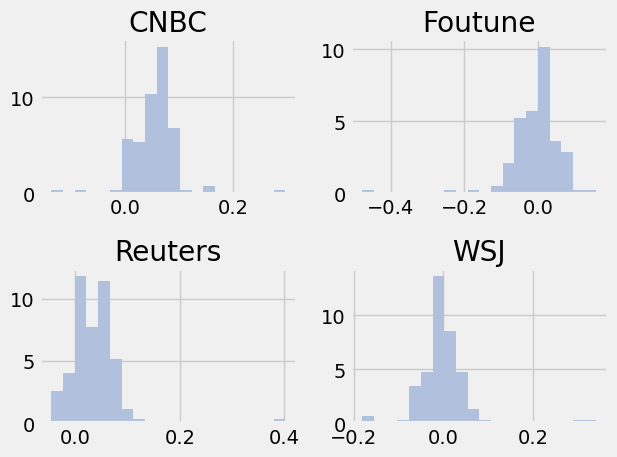

In [12]:
# histogram of sentiment indices
n_bins = 20
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

ax0.hist(merged_df['cnbc_mean_compound'], n_bins, density=True, histtype='bar', color='#b1c1dd')
ax0.set_title('CNBC')

ax1.hist(merged_df['fortune_mean_compound'], n_bins, density=True, histtype='bar', color='#b1c1dd')
ax1.set_title('Foutune')

ax2.hist(merged_df['reuters_mean_compound'], n_bins, density=True, histtype='bar', color='#b1c1dd')
ax2.set_title('Reuters')

ax3.hist(merged_df['wsj_mean_compound'], n_bins, density=True, histtype='bar', color='#b1c1dd')
ax3.set_title('WSJ')

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Sentiment Scores from Four Sources')

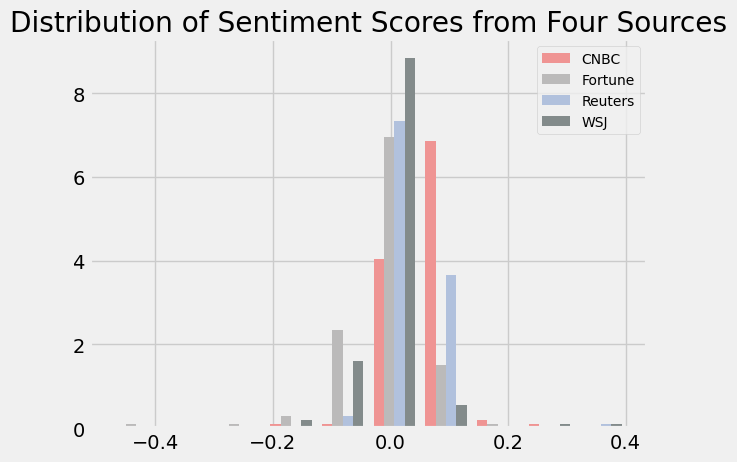

In [11]:
n_bins = 10
fig, ax = plt.subplots()

colors = ['#ef9493', '#bbbaba', '#b1c1dd','#838b8b']
x = merged_df[['cnbc_mean_compound','fortune_mean_compound','reuters_mean_compound', 'wsj_mean_compound']]
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=['CNBC','Fortune','Reuters','WSJ'])
ax.legend(prop={'size': 10})
ax.set_title('Distribution of Sentiment Scores from Four Sources')

In [5]:
def normalize_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - min_val) / (max_val - min_val), min_val[0], max_val[0]

def prepare_data(data, sequence_length):
    windows = [data[i:i+sequence_length] for i in range(len(data) - sequence_length)]
    windows = np.array(windows).astype(float)
    x = windows[:, :-1]
    y = windows[:, -1, [0]]
    return x, y

def add_noise(df, noise=0.1):
    variances = df.var()
    noise_vars = noise * variances
    return df + np.random.normal(0, noise_vars, size=df.shape)

In [6]:
def build_lstm_model(input_timesteps, input_dim, neurons, drop_out):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=True))
    model.add(Dropout(drop_out))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam())
    return model

In [7]:
def build_arima_model(df, target, split):
    cols = [target]
    dataframe = df.copy()
    dataframe = dataframe.get(cols)
    # Split the data
    i_split = int(len(dataframe) * split)
    train_df = dataframe.iloc[:i_split]
    test_df = dataframe.iloc[i_split:]
    # Find the best parameters
    def arimamodel(timeseriesarray):
        autoarima_model = pmd.auto_arima(timeseriesarray, start_p=1, start_q=1,test="adf",trace=True)
        return autoarima_model
    # Fit the ARIMA model
    model = arimamodel(train_df)
    model_fit = model.fit(train_df)
    # Make predictions
    y_pred = model_fit.predict(n_periods=len(test_df))
    y_test = test_df[target].values
    d = pmd.arima.ndiffs(train_df, test="adf")
    y_tpred = model_fit.predict_in_sample(start=d, end=len(train_df)-1)
    y_train = train_df[target].values
    return y_test, y_pred, y_train, y_tpred

In [8]:
def build_rf_model(df, target, split, sequence_length):
    cols = [target, 'wsj_mean_compound', 'cnbc_mean_compound', 'fortune_mean_compound', 'reuters_mean_compound']
    dataframe = df.copy()
    dataframe = dataframe.get(cols)
    # Create lag features for the sentiment columns
    for col in cols[1:]:
        for lag in range(1, sequence_length):
            dataframe[f'{col}_lag{lag}'] = dataframe[col].shift(lag)       
    dataframe = dataframe.dropna()
    i_split = int(len(dataframe) * split)
    train_df = dataframe.values[:i_split]
    test_df = dataframe.values[i_split:]
    x_train = train_df[:, 1:]
    y_train = train_df[:, 0]
    x_test = test_df[:, 1:]
    y_test = test_df[:, 0]
    # Set up the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
    # Instantiate and fit the RandomForest model using GridSearchCV
    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    # Make predictions using the best model
    y_pred = best_model.predict(x_test)
    y_tpred = best_model.predict(x_train)
    return y_test, y_pred, y_train, y_tpred

In [9]:
def run_and_evaluate(df, params, target, method, plot):
    '''
    target - SP, SP_r, NDX, NDX_r, DJI, DJI_r, RUT, RUT_r
    method - no sentiment, with sentiment, DP, arima, rf
    '''

    if method == 'arima':
        y_test_denorm, y_pred_denorm, y_train_denorm, y_tpred_denorm = build_arima_model(df, target, params['split'])
    elif method == 'rf':
        y_test_denorm, y_pred_denorm, y_train_denorm, y_tpred_denorm = build_rf_model(df, target, params['split'], params['sequence_length'])
    else:
        dataframe = df.copy()
        if method == 'no sentiment':
            cols = [target]            
        elif method == 'with sentiment':
            cols = [target, 'wsj_mean_compound', 'cnbc_mean_compound', 'fortune_mean_compound', 'reuters_mean_compound']       
        else:
            cols = [target, 'wsj_mean_compound', 'cnbc_mean_compound', 'fortune_mean_compound', 'reuters_mean_compound']        
            dataframe.iloc[:, 8:] = add_noise(dataframe.iloc[:, 8:])

        i_split = int(len(dataframe) * params['split'])
        data_train = dataframe.get(cols).values[:i_split]
        data_test = dataframe.get(cols).values[i_split:]

        data_train, train_min, train_max = normalize_data(data_train)
        data_test, test_min, test_max = normalize_data(data_test)

        x_train, y_train = prepare_data(data_train, params['sequence_length'])
        x_test, y_test = prepare_data(data_test, params['sequence_length'])

        model = build_lstm_model(x_train.shape[1], x_train.shape[2], params['neurons'], params['drop_out'])
        model.fit(x_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'])

        y_pred = model.predict(x_test)
        y_tpred = model.predict(x_train)

        y_test_denorm = y_test * (test_max - test_min) + test_min
        y_pred_denorm = y_pred * (test_max - test_min) + test_min
        y_train_denorm = y_train * (train_max - train_min) + train_min
        y_tpred_denorm = y_tpred * (train_max - train_min) + train_min
        
    # evaluation
    error = y_test_denorm - y_pred_denorm
    mse = np.mean(np.square(error))
    mae = np.mean(np.abs(error))
    error_percent = np.abs(error) / y_test_denorm
    mean_error_percent = np.mean(error_percent)
    accuracy = 1 - mean_error_percent
    R2 = r2_score(y_test_denorm, y_pred_denorm)
    
    if plot:    
        print("MSE:", mse)
        print("MAE:", mae)
        print("R-square:", R2)
        print("Accuracy:", accuracy)
        print("Mean Error Percent:", mean_error_percent)
    
    return y_pred_denorm, y_tpred_denorm, mse, mae, R2, accuracy, mean_error_percent

In [37]:
params = {
    'split': 0.85,
    'sequence_length': 10,
    'batch_size': 20,
    'neurons': 50,
    'epochs': 10,
    'drop_out': 0
}

In [11]:
# lstm - no sentiment
y_pred_denorm1, y_tpred_denorm1 = run_and_evaluate(merged_df, params, 'SP', 'no sentiment', plot=1)[0:2]

Epoch 1/10


2023-04-30 15:51:32.180579: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 1s 12ms/step - loss: 0.1757
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0571
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0696
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 375.73341362343893
MAE: 17.79739040798611
R-square: -1.0987377656003074
Accuracy: 0.9934633348998849
Mean Error Percent: 0.006536665100115045


In [12]:
# lstm - with sentiment
y_pred_denorm2, y_tpred_denorm2 = run_and_evaluate(merged_df, params, 'SP', 'with sentiment',plot=1)[0:2]

Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1765
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0638
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0587
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 451.86291435029773
MAE: 19.37282986111111
R-square: -1.5239750547488375
Accuracy: 0.9928881757366406
Mean Error Percent: 0.007111824263359422


In [13]:
# lstm - DP
y_pred_denorm3, y_tpred_denorm3 = run_and_evaluate(merged_df, params, 'SP', 'DP', plot=1)[0:2]

Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1714
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0518
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0611
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 301.1655342512661
MAE: 15.860487196180555
R-square: -0.6822232399692423
Accuracy: 0.9941737684533279
Mean Error Percent: 0.005826231546672075


In [14]:
# arima
y_pred_denorm4, y_tpred_denorm4 = run_and_evaluate(merged_df, params, 'SP', 'arima', plot=1)[0:2]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=974.874, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=976.836, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=976.802, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=972.882, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.105 seconds
MSE: 3004.078976932325
MAE: 51.520070929276315
R-square: -7.588941225231297
Accuracy: 0.9810704327225296
Mean Error Percent: 0.018929567277470468


/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
# random forest
y_pred_denorm5, y_tpred_denorm5 = run_and_evaluate(merged_df, params, 'SP', 'rf', plot=1)[0:2]

Fitting 5 folds for each of 108 candidates, totalling 540 fits
MSE: 389.20550826134433
MAE: 14.746980497396688
R-square: -1.568231501614079
Accuracy: 0.9945815556586184
Mean Error Percent: 0.005418444341381655


In [57]:
def plot_results(target, sequence_length, y_pred_denorm1, y_tpred_denorm1,y_pred_denorm2, y_tpred_denorm2,y_pred_denorm3, y_tpred_denorm3,y_pred_denorm4, y_tpred_denorm4,y_pred_denorm5, y_tpred_denorm5):
    df_result = pd.DataFrame()
    nan_size = len(y_tpred_denorm1)
    df_result['date'] = merged_df.reset_index()['index'][sequence_length:-sequence_length]
    df_result['target'] = merged_df.reset_index()[target][sequence_length:-sequence_length]
    df_result['pred_no_senti'] = [None]*nan_size + y_pred_denorm1.ravel().tolist()
    df_result['pred_with_senti'] = [None]*nan_size + y_pred_denorm2.ravel().tolist()
    df_result['pred_DP'] = [None]*nan_size + y_pred_denorm3.ravel().tolist()
    df_result['pred_arima'] = [None]*(nan_size-(len(y_pred_denorm4)-len(y_pred_denorm1))) + y_pred_denorm4.ravel().tolist()
    df_result['pred_rf'] = [None]*(nan_size-(len(y_pred_denorm5)-len(y_pred_denorm1))) + y_pred_denorm5.ravel().tolist()

    fig = px.line(df_result, x='date', y=df_result.columns[1:], title="Actual Vs Predicted",width=600, height=350)
    # fig.update_yaxes(range=[2200, 3000])
    fig.show()
    return

In [58]:
def run_and_plot(target, sequence_length):
    y_pred_denorm1, y_tpred_denorm1 = run_and_evaluate(merged_df, params, target, 'no sentiment', plot=1)[0:2]
    y_pred_denorm2, y_tpred_denorm2 = run_and_evaluate(merged_df, params, target, 'with sentiment', plot=1)[0:2]
    y_pred_denorm3, y_tpred_denorm3 = run_and_evaluate(merged_df, params, target, 'DP', plot=1)[0:2]
    y_pred_denorm4, y_tpred_denorm4 = run_and_evaluate(merged_df, params, target, 'arima', plot=1)[0:2]
    y_pred_denorm5, y_tpred_denorm5 = run_and_evaluate(merged_df, params, target, 'rf', plot=1)[0:2]
    plot_results(target, sequence_length, y_pred_denorm1, y_tpred_denorm1,y_pred_denorm2, y_tpred_denorm2,y_pred_denorm3, y_tpred_denorm3,y_pred_denorm4, y_tpred_denorm4,y_pred_denorm5, y_tpred_denorm5)
    return

In [59]:
run_and_plot('SP', params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1797
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0710
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0519
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0391
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
MSE: 320.2178218232261
MAE: 16.55105251736111
R-square: -0.7886437870873215
Accuracy: 0.9939186751060128
Mean Error Percent: 0.006081324893987167
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1818
Epoch 2/10
5/5 [==

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 389.20550826134433
MAE: 14.746980497396688
R-square: -1.568231501614079
Accuracy: 0.9945815556586184
Mean Error Percent: 0.005418444341381655


In [60]:
run_and_plot('SP_r',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2998
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0999
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
MSE: 5.036289086082046e-05
MAE: 0.006162242296867311
R-square: -0.05240861126318985
Accuracy: 1.7801905161239362
Mean Error Percent: -0.7801905161239362
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2951
Epoch 2/10


/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 5.918568889152362e-05
MAE: 0.006251555621835947
R-square: -0.3100752340856445
Accuracy: 1.1086049119945471
Mean Error Percent: -0.10860491199454712


In [61]:
run_and_plot('NDX',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2504
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1024
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0600
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 1286.973669581943
MAE: 32.70160590277778
R-square: -0.018477262192417854
Accuracy: 0.9952840831456008
Mean Error Percent: 0.004715916854399188
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2108
Epoch 2/10
5/5 [

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 44847.25600195334
MAE: 185.57509459347426
R-square: -17.96479006874436
Accuracy: 0.9733442702201723
Mean Error Percent: 0.026655729779827716


In [62]:
run_and_plot('NDX_r',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2602
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1027
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0404
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 8/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0358
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0334
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 2.4098435946952395e-05
MAE: 0.004264674972309325
R-square: -0.04252141574844903
Accuracy: 1.5877558717850562
Mean Error Percent: -0.5877558717850562
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2365
Epoch 2/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 6.853274965518164e-05
MAE: 0.006955471207970092
R-square: -0.4248728721845165
Accuracy: 1.5108998652101011
Mean Error Percent: -0.5108998652101012


In [63]:
run_and_plot('DJI',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1741
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0654
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 46235.86263656616
MAE: 175.00629340277777
R-square: -0.155173717934874
Accuracy: 0.9929056095451686
Mean Error Percent: 0.0070943904548313765
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1682
Epoch 2/10
5/5 [=

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 79804.73803611925
MAE: 222.06971557457783
R-square: -2.03978852658514
Accuracy: 0.9909840880028878
Mean Error Percent: 0.009015911997112143


In [64]:
run_and_plot('DJI_r',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3112
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1155
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 7.938193458626727e-05
MAE: 0.0073888939072969
R-square: -0.0017099029121134812
Accuracy: -3.214326182597362
Mean Error Percent: 4.214326182597362
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2789
Epoch 2/10
5/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 5.592461301609355e-05
MAE: 0.006096188995588332
R-square: -0.03698261240377021
Accuracy: 0.15154776248122992
Mean Error Percent: 0.8484522375187701
Fitting 5 folds for each of 108 candidates, totalling 540 fits
MSE: 8.495883337174707e-05
MAE: 0.007060052650498399
R-square: -0.42384920594904085
Accuracy: -2.063035221800117
Mean Error Percent: 3.063035221800117


In [65]:
run_and_plot('RUT',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3658
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1913
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0636
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0726
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0546
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0479
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
MSE: 259.86773576339084
MAE: 14.367024739583334
R-square: -3.885620093788277
Accuracy: 0.9912058848702004
Mean Error Percent: 0.008794115129799579
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2903
Epoch 2/10
5/5 [=

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 5246.326688419017
MAE: 71.09660343077745
R-square: -20.898087308928677
Accuracy: 0.9562377071197368
Mean Error Percent: 0.04376229288026327


In [66]:
run_and_plot('RUT_r',params['sequence_length'])

Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3390
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1334
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0687
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0467
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
MSE: 5.33836250664532e-05
MAE: 0.006216568317809195
R-square: -0.18615949240586538
Accuracy: 0.5328922977452042
Mean Error Percent: 0.46710770225479575
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3094
Epoch 2/10
5

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE: 4.84389550882233e-05
MAE: 0.005531565696017987
R-square: -0.35135263847223963
Accuracy: -inf
Mean Error Percent: inf


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



In [18]:
# run 10 times and take the average
def get_average_metrics(target, metrics):
    '''
    2 - mse
    3 - mae
    4 - R2
    5 - accuracy
    6 - mean_error_percent
    
    '''
    met_no_senti = []
    met_with_senti = []
    met_DP = []
    met_arima = []
    met_rf = []    
    for i in range(10):
        met_no_senti.append(run_and_evaluate(merged_df, params, target, 'no sentiment',0)[metrics])
        met_with_senti.append(run_and_evaluate(merged_df, params, target, 'with sentiment',0)[metrics])
        met_DP.append(run_and_evaluate(merged_df, params, target, 'DP',0)[metrics])
        met_arima.append(run_and_evaluate(merged_df, params, target, 'arima',0)[metrics])
        met_rf.append(run_and_evaluate(merged_df, params, target, 'rf',0)[metrics])
    return np.mean(met_no_senti), np.mean(met_with_senti), np.mean(met_DP), np.mean(met_arima), np.mean(met_rf)

In [20]:
# get the total result
def get_total_result(metrics):
    targets = ['SP', 'SP_r', 'NDX', 'NDX_r', 'DJI', 'DJI_r', 'RUT', 'RUT_r']
    final_result = pd.DataFrame(index=targets, columns=['no_senti','with_senti', 'dp', 'arima', 'rf'])
    met_no_senti = []
    met_with_senti = []
    met_DP = []
    met_arima = []
    met_rf = [] 
    for target in targets:
        print(target)
        met1, met2, met3, met4, met5 = get_average_metrics(target,metrics)
        met_no_senti.append(round(met1,4))
        met_with_senti.append(round(met2,4))
        met_DP.append(round(met3,4))
        met_arima.append(round(met4,4))
        met_rf.append(round(met5,4))
    final_result['no_senti'] = met_no_senti
    final_result['with_senti'] = met_with_senti
    final_result['dp'] = met_DP
    final_result['arima'] = met_arima
    final_result['rf'] = met_rf
    return final_result

In [22]:
final_result_mse = get_total_result(2)
final_result_mae = get_total_result(3)
final_result_R2 = get_total_result(4)
final_result_accuracy = get_total_result(5)
final_result_mean_error_percent = get_total_result(6)

SP
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1734
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0634
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1584
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0531
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0606
Epoch 

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1954
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0806
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0578
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1955
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0600
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1864
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0756
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2242
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0641
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0649
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2006
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0952
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0398
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0415
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1760
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0499
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0653
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1881
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0705
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0439
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1556
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0597
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1879
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0799
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0611
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2024
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0691
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0601
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1937
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0750
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1655
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0576
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1801
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0633
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0668
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2137
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0891
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2238
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1158
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1949
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0641
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1900
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0877
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1775
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0571
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0632
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2968
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0874
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.1986
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0480
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoc

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2540
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0628
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2766
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0583
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0675
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 10ms/step - loss: 0.3309
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1283
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0502
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0307
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0311
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2656
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0606
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.3017
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0877
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2914
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.0707
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0579
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3005
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0907
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0600
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2399
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0473
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3017
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0997
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2921
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0594
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0697
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3062
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0952
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3378
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1075
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 14ms/step - loss: 0.3157
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0982
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0589
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2286
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0510
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3193
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1222
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1911
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0589
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2970
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0935
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0696
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3098
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0710
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0667
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2324
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0780
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0817
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2173
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0631
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0709
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2294
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0908
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2326
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0710
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0689
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2504
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.1037
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0685
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0526
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 8/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0471
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2046
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0480
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0668
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2395
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1044
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2340
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0651
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0705
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2491
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1231
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2304
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0704
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0726
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2167
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0792
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0634
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2260
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0750
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0622
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2377
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0953
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0644
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0481
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2173
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0573
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0663
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2345
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0932
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0771
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1813
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0596
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2550
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1183
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 6/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0509
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2139
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0683
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0589
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2093
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0591
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0835
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2174
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0636
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0716
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2418
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0834
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1961
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0468
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0518
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1993
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0446
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2191
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0454
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0596
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2646
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1111
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0395
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2319
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0591
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2442
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0959
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0642
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 19ms/step - loss: 0.2054
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0483
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0525
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2161
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0618
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0403
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2216
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0484
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2707
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1046
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0546
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2448
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0507
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0729
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 17ms/step - loss: 0.2489
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0867
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0583
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2323
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0628
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2485
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0882
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0595
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1627
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0507
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2757
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1308
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2016
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0516
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2713
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1027
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0630
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2284
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0459
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0634
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1958
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0806
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1763
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0628
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1856
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0625
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.1879
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0502
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1946
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0677
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1870
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0605
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1897
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0734
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1938
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0613
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0617
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1927
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0640
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1874
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0567
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0604
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1895
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0711
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1556
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0586
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2007
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0850
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0511
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 8/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0387
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1478
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0635
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1931
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0791
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0542
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1785
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0613
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1993
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0723
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1897
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0621
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0611
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1931
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0809
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1564
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0623
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI_r
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3092
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1025
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2879
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0501
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0660
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3332
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1107
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0547
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3055
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0578
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0683
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3502
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1370
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2288
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0482
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3595
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1630
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.3450
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0676
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3087
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0949
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0696
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3225
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0757
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 14ms/step - loss: 0.3239
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.0977
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0576
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0377
Epoch 5/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0366
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0312
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0300
Epoch 8/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0299
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2346
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0507
Epoch 3/10
5/5 [======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3489
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1632
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0309
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2655
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3069
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0989
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0713
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2952
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0676
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2706
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0643
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0702
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2910
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0540
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3239
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1125
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3120
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0624
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3160
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1010
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0996
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0650
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0591
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2869
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0700
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0944
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3440
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1498
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0670
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0695
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3279
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0878
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0765
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3443
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1708
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0640
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0667
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2704
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0627
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0784
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3528
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1679
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0646
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3099
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0979
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0657
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3131
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1209
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0740
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0570
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2765
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0776
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0777
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3147
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1217
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0887
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0559
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3118
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0789
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0773
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3500
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1679
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0597
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3121
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0793
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0718
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2927
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1034
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0664
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3331
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0881
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0865
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3061
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1065
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0842
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3427
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1240
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2823
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0754
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0861
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0570
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0491
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3088
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0749
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0791
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT_r
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3600
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1623
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3055
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0747
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0682
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3486
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1198
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0678
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2616
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0682
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3416
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1424
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3108
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0665
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0772
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 12ms/step - loss: 0.3287
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1313
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0818
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2565
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0525
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0608
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3623
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1619
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0568
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 9/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0378
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2481
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0596
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0593
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.3749
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1600
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0495
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2395
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0490
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.3117
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0943
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0752
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3343
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0752
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0663
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 12ms/step - loss: 0.3437
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1500
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0601
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3343
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0979
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0720
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 12ms/step - loss: 0.3418
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1464
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2409
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0583
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0595
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 16ms/step - loss: 0.3194
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.1005
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0728
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2987
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0650
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0695
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



SP
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2126
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1072
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2198
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0720
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0604
Epoch 

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2069
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0979
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0638
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1401
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0730
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2104
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1030
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2188
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0647
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1790
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0563
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2192
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0803
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0664
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1958
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0718
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1370
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0517
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2167
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0974
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1664
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0508
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1794
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0781
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2160
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0691
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0593
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1995
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0836
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1599
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0692
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0578
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1653
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0567
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0734
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1611
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0525
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0635
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.2188
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1094
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0557
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1917
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0518
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0675
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP_r
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2832
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0814
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3176
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0884
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0584
Epoc

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3186
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1252
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2858
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0724
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2793
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0699
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0735
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2346
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0540
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3439
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1446
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2792
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0470
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0642
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3311
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1451
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3061
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0795
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0637
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3254
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1217
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2425
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0446
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2940
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0935
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2045
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0437
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2941
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0887
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0632
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0361
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3209
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1028
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3275
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1320
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0598
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2286
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0460
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.3030
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1012
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0617
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2919
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0702
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0578
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2258
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0815
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2290
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0725
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0763
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2341
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1038
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1887
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0688
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 16ms/step - loss: 0.2250
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.0730
Epoch 3/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0840
Epoch 4/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0459
Epoch 5/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0561
Epoch 6/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0528
Epoch 7/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0450
Epoch 8/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0460
Epoch 9/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0443
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1949
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0697
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.2396
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1096
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0604
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2017
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0465
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0810
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2349
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0895
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0634
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2418
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0803
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0681
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2230
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0781
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0631
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1918
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0582
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2677
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1441
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0667
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2246
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0598
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0738
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2528
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1313
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0646
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1411
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0602
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2208
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0794
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0829
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0510
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0433
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2402
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0806
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0715
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2543
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1170
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0635
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0510
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2187
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0608
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0736
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX_r
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2250
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0744
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2267
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0470
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0655
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2688
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1178
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0539
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2273
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0601
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2735
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1056
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2288
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0516
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2454
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0873
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2421
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0557
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0631
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2284
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0737
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0636
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2646
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0640
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2417
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0879
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0581
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2352
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2682
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1249
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0475
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 15ms/step - loss: 0.2227
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0411
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0567
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2567
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1026
Epoch 3/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0517
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1540
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0667
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0403
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2339
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0706
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2109
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0486
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0495
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2617
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1114
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2190
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0571
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2051
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0821
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1560
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0506
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1842
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0711
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1687
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0650
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2019
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0796
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1777
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0561
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2104
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0794
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1951
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0604
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0649
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2001
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0756
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1492
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0571
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2006
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0832
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2019
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0611
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0629
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2049
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0837
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0495
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2407
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0655
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0730
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1987
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0689
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2008
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0630
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1866
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0517
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0704
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0401
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1468
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0608
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1922
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0697
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1363
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0601
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI_r
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3491
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1685
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0540
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2015
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0430
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3057
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0941
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3373
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0947
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3183
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0999
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2912
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0590
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3058
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1016
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0635
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3488
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1046
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3264
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0945
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0371
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2413
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0442
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3352
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1364
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3165
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0951
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0614
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2999
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1027
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3238
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0810
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3151
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1196
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 4/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0396
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0393
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2321
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0445
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2974
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0768
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0664
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0284
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3078
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0650
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.3506
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1677
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0495
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2943
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0711
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
RUT
Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.3523
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1552
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0711
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0711
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0555
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3360
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1022
Epoch 3/10
5/5 [===

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2921
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1049
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0780
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.2817
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0625
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0877
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.3105
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0991
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0752
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3305
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1104
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0881
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2917
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0847
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0916
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0595
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3128
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0779
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0937
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3239
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1253
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0806
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0603
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3524
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1053
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0827
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3811
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.2149
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0895
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0601
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2416
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0683
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0559
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2753
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0825
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0865
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0491
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0603
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0576
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3185
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0809
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0781
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2972
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1055
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0670
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0481
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2714
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0667
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0769
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3277
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1331
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0762
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3145
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0724
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0747
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3007
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0936
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1020
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0630
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 7/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0453
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2902
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0744
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0774
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT_r
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3260
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0913
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0731
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2299
Epoch 2/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0613
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0519
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2997
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0965
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0648
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2831
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0568
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0650
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.3388
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1083
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0746
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 26ms/step - loss: 0.3900
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1464
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0604
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3535
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1646
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2652
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0542
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0691
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2667
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0648
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0749
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0527
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3478
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0755
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0767
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.3519
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1388
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0597
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2355
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0567
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.3573
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1495
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2598
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0558
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.3446
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1454
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 9/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0366
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2811
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0680
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0631
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3464
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1468
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0576
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.3257
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0649
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0746
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.3491
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1438
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3084
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0804
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0648
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP
Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.1809
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0693
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1893
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0580
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0650
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1962
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0738
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1447
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0505
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0591
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1928
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0721
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 15ms/step - loss: 0.1232
Epoch 2/10
5/5 [==============================] - 0s 15ms/step - loss: 0.0581
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0489
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1909
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0682
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1966
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0655
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0629
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1871
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0560
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1477
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0553
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2029
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0850
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 23ms/step - loss: 0.1436
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0608
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0535
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1902
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0732
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1469
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0603
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2051
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0965
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1970
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0584
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0751
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2020
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0846
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0519
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2140
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0628
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0721
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 19ms/step - loss: 0.2002
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0862
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2157
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0661
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0678
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2960
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0995
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2235
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0423
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0523
Epoc

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3417
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1314
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3040
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0702
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3145
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1165
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2694
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0673
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3124
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1308
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0327
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2491
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0604
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2825
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0784
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0665
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3362
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1096
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3148
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1115
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0608
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0390
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2640
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0476
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2922
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0871
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0320
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.2082
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0525
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3127
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1128
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0479
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2581
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0500
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0577
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 16ms/step - loss: 0.3321
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.1452
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0482
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 8/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3294
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0959
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0554
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3176
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1311
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2673
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0563
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2661
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1471
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0673
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 10/10
3/3 [==============================] - 0s 6ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1720
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0532
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2642
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1354
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0618
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2346
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0654
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0718
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2278
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0845
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2079
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0665
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0703
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2260
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0849
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0663
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 8/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0446
Epoch 9/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1829
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0548
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0587
Epoch 4

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2439
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1055
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0640
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0432
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1721
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0590
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0567
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2552
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1167
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0662
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2084
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0632
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0683
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2436
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0953
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2283
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0508
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0705
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2317
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0905
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0641
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0495
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0489
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1843
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0627
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0590
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2506
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1037
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0542
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1933
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0625
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2314
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0906
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0557
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0534
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2259
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0548
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0780
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX_r
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2282
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0588
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0692
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1897
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2376
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0762
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0574
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1653
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0491
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2345
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0718
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1987
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0549
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2526
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0919
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2083
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0513
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2561
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1027
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0332
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2322
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0579
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0675
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2514
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0856
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0632
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2570
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0456
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0673
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2548
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0914
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2412
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0483
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2590
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1137
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2672
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0483
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0665
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2491
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0957
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0555
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2089
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0532
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0562
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2646
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0874
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0386
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2216
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0513
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0591
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2138
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1071
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1331
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0632
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2108
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0920
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1583
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0536
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1445
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0431
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1794
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0520
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1887
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0810
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0495
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.1576
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0639
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0600
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1957
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0603
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1664
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0729
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1752
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0539
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0622
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1917
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0604
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2068
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0802
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2015
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0619
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1700
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0596
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0660
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1832
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0625
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0587
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1447
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0549
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0372
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1893
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0468
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1887
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0702
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1451
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0484
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI_r
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2596
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0606
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 9/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0294
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1995
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0499
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Ep

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3226
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1142
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0562
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0314
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2870
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0534
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3408
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1444
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0557
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 7/10
5/5 [==============================] - 0s 42ms/step - loss: 0.0301
Epoch 8/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0323
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0287
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3839
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1022
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0600
Epoch 4

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2801
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0684
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0642
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0309
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2653
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0459
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3113
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0953
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0652
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3413
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0837
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0669
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 19ms/step - loss: 0.2887
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.0776
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0684
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0436
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3187
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0797
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2938
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0791
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0651
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0327
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3301
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0910
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3198
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1108
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0704
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0285
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2936
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0710
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3219
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1245
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3057
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0626
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3422
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1356
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0510
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3103
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0662
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3021
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1044
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.1028
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0649
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0636
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2641
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0799
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0656
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3337
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1353
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0744
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3150
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0823
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0806
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3098
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1036
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0831
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3084
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0821
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0772
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3741
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1481
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0671
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3282
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0919
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0832
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3733
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1914
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0669
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0719
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0491
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3070
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0786
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0708
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.3098
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1099
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0756
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0555
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0519
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 9/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2535
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0709
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0687
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3253
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1188
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0797
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3342
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0921
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0676
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2984
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0993
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0873
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0575
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.2723
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0599
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0717
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3609
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1716
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0706
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2879
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0774
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0755
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.3129
Epoch 2/10
5/5 [==============================] - 0s 30ms/step - loss: 0.1244
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0697
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0566
Epoch 5/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0524
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0507
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0447
Epoch 8/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0465
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0447
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.3417
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.1098
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0877
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3649
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1768
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0596
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2998
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0675
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0638
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.3347
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1202
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0781
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3339
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0866
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0741
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 12ms/step - loss: 0.3381
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1319
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3131
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0672
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0712
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 12ms/step - loss: 0.3887
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.2027
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0726
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3097
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0727
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0714
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3425
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1295
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2742
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0520
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0732
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.3337
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0975
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0750
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2946
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0664
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0671
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 12ms/step - loss: 0.3448
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1216
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0608
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2563
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0543
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0608
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3484
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1462
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0586
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3086
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0754
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0665
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3546
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1499
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0569
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2835
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0524
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0649
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3203
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0983
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0888
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0401
Epoch 9/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0392
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3395
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0985
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0590
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



SP
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2017
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0738
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1180
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0589
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2093
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1007
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0535
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 30ms/step - loss: 0.2050
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0608
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0690
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2141
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0959
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0562
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1948
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0547
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0678
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1983
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0834
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1969
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0567
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0665
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1888
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0674
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0647
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1633
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0504
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0645
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1945
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0819
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2104
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0791
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0634
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2106
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0918
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1490
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.2154
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0872
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1608
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0641
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.2023
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0922
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0608
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0492
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1386
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0705
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1888
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0684
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0673
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1469
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0439
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0587
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP_r
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2750
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0652
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2439
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0527
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0535
Epoc

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3210
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1451
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2201
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0462
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2826
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0875
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0596
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2502
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0573
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2819
Epoch 2/10
5/5 [==============================] - 0s 22ms/step - loss: 0.0798
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0646
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 8/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0334
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0301
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3305
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0885
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3301
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1202
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2992
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0670
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0688
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3328
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1343
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0320
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3017
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0757
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3131
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1208
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3212
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0844
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0634
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3308
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1364
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2627
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0596
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3575
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1548
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0356
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0571
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 6/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0414
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0317
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2213
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0408
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3149
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1167
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2852
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0617
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2349
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0855
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0709
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2231
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0612
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0692
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2433
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1018
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0788
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0541
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1605
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0617
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0609
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2056
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0684
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0670
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2057
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0549
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0680
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2323
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0888
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0491
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0485
Epoch 7/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0435
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 27ms/step - loss: 0.1829
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0605
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0702
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2404
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1084
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2373
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0691
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0677
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2241
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0884
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0601
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2086
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0636
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0644
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1989
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0620
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0807
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2545
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0903
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0684
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2419
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0884
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0736
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1845
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0644
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0575
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2204
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0883
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0687
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2022
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0678
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2253
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0813
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0676
Epoch 4/10
5/5 [==============================] - 0s 27ms/step - loss: 0.0572
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2076
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0645
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0656
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX_r
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2238
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0747
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1415
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0552
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2647
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0966
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2445
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0510
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2497
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0817
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2206
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0574
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2569
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0996
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0557
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0388
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0329
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2357
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0578
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2439
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0812
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0603
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2664
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0541
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0643
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2256
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0665
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2628
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0717
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.2486
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0960
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2171
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0499
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2442
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0909
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2509
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0683
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0591
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2880
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1323
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1625
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0439
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2664
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1151
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0481
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2787
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1017
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0522
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1829
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0560
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 10ms/step - loss: 0.1821
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0591
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2007
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0864
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1871
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0518
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0695
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2150
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0960
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 4/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0503
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1821
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0650
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0542
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 17ms/step - loss: 0.1970
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0911
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0508
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0452
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1487
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0572
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1933
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0716
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1582
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0600
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1730
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0630
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1756
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0534
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2098
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1062
Epoch 3/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0472
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1574
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0617
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2059
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0885
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1763
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0555
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0631
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1908
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0723
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1417
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0557
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2066
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0942
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1676
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0579
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0539
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI_r
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3145
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1079
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0637
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3248
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0659
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0609
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3270
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1258
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0417
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 7/10
5/5 [==============================] - 0s 9ms/step - loss: 0.0290
Epoch 8/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0337
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3173
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0784
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3225
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1140
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0618
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2007
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0619
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3442
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1393
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2350
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0605
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3491
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1593
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0570
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0569
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0332
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0374
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0304
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 9/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0303
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2929
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0475
Epoch 3/10
5/5 [======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2986
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0811
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0742
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3454
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0983
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3387
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1442
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3115
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0777
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3627
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1530
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0456
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2622
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0516
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3283
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1062
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3203
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1135
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.3275
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 0.1274
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2844
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0561
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
RUT
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3153
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1174
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0661
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 9/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0434
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3410
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1000
Epoch 3/10
5/5 [===

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3410
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1501
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0757
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0621
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2844
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0690
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0689
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3440
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1414
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0606
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3053
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1049
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0722
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3423
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1605
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0606
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2223
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0731
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3218
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1044
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0513
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0510
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2533
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0619
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0681
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3439
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1335
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0703
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0628
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0510
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3151
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0963
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0812
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3226
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1238
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0969
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0558
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0626
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2449
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0708
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0678
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3327
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1312
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0869
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0570
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 8/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0463
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0451
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3066
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0616
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0885
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 22ms/step - loss: 0.3117
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1248
Epoch 3/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0682
Epoch 4/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0551
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0480
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 9/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3157
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0774
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0761
Epoch 4

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3221
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1262
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0679
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0550
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 14ms/step - loss: 0.2974
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0870
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0695
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3187
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1055
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0829
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2430
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0594
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0580
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.2979
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0841
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0704
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 7/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0416
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 9/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0375
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3040
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0657
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0771
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3260
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.1012
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0646
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 8/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0383
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.3133
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0707
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3382
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0988
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0690
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2655
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0646
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 12ms/step - loss: 0.3181
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1063
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0717
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3364
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0907
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 12ms/step - loss: 0.3553
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1313
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0762
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3123
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0691
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0670
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3088
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0933
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0715
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 14ms/step - loss: 0.2123
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0495
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3535
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1441
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0620
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3518
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1045
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 15ms/step - loss: 0.3149
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0955
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0673
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0385
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3847
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1210
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.3365
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1427
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2862
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0552
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0724
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP
Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.2280
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1124
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0559
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0575
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1158
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0600
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1989
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0816
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0562
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1626
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0505
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1886
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0761
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0578
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1703
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1930
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0785
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1615
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0609
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0600
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2124
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1027
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.1684
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0621
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0567
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.1980
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0817
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0479
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1728
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0556
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0614
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1680
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0510
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1919
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0689
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1913
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0705
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0553
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1630
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0575
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0635
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1991
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0709
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1527
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0582
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.1966
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0782
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0637
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2095
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0673
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SP_r
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3118
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1134
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2529
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0554
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoc

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3053
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1094
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0554
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3077
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0777
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0604
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.2970
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0964
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0649
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0330
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2933
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0941
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0652
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2845
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0924
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0533
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2702
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0481
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3016
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0950
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0568
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 13ms/step - loss: 0.2604
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0434
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0623
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3130
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0961
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0691
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2457
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0540
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0557
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3510
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1857
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2693
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0573
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2853
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0941
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2580
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0550
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3088
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1053
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2924
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0633
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3238
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1419
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0491
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0305
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1765
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0482
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2301
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0992
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2209
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0714
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0692
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2260
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0838
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0651
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0489
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1728
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0579
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2361
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0962
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1854
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0544
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2332
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0862
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0737
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2091
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0662
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0632
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2221
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0809
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0645
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2404
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0775
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0654
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2272
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0791
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0779
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0483
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0524
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2188
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0604
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0726
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2677
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1180
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0576
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0451
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2456
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0792
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0730
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2510
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1040
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0570
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0481
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1691
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0663
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2420
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1031
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0518
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1635
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0564
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2456
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1069
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0639
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1922
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0652
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



NDX_r
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2431
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0866
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0690
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0472
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1877
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0405
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0514
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2570
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1032
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2386
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0553
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2680
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1004
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0346
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1984
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0412
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2818
Epoch 2/10
5/5 [==============================] - 0s 15ms/step - loss: 0.1230
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0529
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1937
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0498
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 19ms/step - loss: 0.2705
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.1173
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 14ms/step - loss: 0.2357
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0582
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0540
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2587
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1043
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2503
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0634
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2197
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0519
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0669
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2022
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0528
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.2169
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0586
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0623
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1977
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0543
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2546
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0851
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 15ms/step - loss: 0.2446
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0571
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0676
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2381
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0757
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1794
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0489
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



DJI
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1917
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0742
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1629
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0566
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2155
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0871
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0535
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1285
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0546
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1743
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0673
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1837
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0625
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0577
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 18ms/step - loss: 0.1856
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0604
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0631
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0431
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 9/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0356
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1376
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0602
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1764
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0578
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1889
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0565
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0646
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1880
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0654
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0657
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0352
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1394
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0623
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2039
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0710
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0588
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2100
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0732
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1740
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0677
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0392
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0349
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1472
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0620
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2244
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1115
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0472
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0384
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 9/10
5/5 [==============================] - 0s 8ms/step - loss: 0.0374
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1547
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0594
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1849
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0615
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0679
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0482
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0437
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2003
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0639
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0644
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
DJI_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3637
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1739
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0539
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3049
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0727
Epoch 3/10
5/5 [=

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2851
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0689
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0756
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0333
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3134
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0696
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 13ms/step - loss: 0.3150
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1148
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0389
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0324
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3016
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0677
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.0597
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3470
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1486
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2713
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0529
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0604
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3092
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1036
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0503
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0285
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2463
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0442
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0649
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3504
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1735
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0539
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2957
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0551
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3299
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1159
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0368
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3422
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0708
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2585
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0535
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0630
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0355
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0301
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2955
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0812
Epoch 3/10
5/5 [=======

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3000
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0847
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0746
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0294
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2085
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0473
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2974
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0882
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0523
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0284
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2572
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0581
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Fitting 5 folds for each of 108 candidates, totalling 540 fits
RUT
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3122
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1160
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0936
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0574
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0618
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0495
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2781
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0741
Epoch 3/10
5/5 [===

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3519
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1796
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0623
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0696
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0546
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3107
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0893
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0765
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2889
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1040
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0717
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0573
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2636
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0688
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0722
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3021
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1097
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0816
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3715
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1248
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0751
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3015
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0896
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0826
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0604
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0517
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0448
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2932
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0768
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0767
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3182
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1060
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0666
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0491
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 9/10
5/5 [==============================] - 0s 23ms/step - loss: 0.0451
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 0.3185
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0842
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0762
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3260
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1408
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0691
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0637
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0564
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2097
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0661
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3164
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1238
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0712
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0521
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0460
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2035
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0603
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3754
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.2002
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0715
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0701
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0525
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0462
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3028
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0816
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0788
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3151
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.1167
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0781
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0574
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0546
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0450
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2733
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0554
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0683
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



RUT_r
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2686
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0735
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0437
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2837
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0637
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0720
Epo

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 11ms/step - loss: 0.3691
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1619
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0497
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3256
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0759
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0625
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 12ms/step - loss: 0.3378
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1211
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0782
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3434
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0973
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0723
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 12ms/step - loss: 0.3535
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1297
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0735
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0507
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2977
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0686
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0716
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.2974
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0866
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0792
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0405
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3371
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0900
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0694
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 2s 12ms/step - loss: 0.3291
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1247
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0709
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.3270
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0682
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0682
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.3562
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1367
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0635
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0530
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2846
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0675
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.3267
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0989
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0704
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3246
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0878
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0765
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.3357
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.1113
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0690
Epoch 4/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0443
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0472
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0487
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0378
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2853
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0586
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0693
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10


/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



5/5 [==============================] - 1s 11ms/step - loss: 0.2698
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0678
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0714
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0448
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0481
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0383
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0379
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2119
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0580
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 4/10
5/5 [====

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/xs/8j5wp_0n63sgshz6v01csbpc0000gn/T/ipykernel_1140/6353071.py:46: RuntimeWarning:

divide by zero encountered in divide



In [23]:
final_result_mse

,no_senti,with_senti,dp,arima,rf
SP,335.6792,350.8661,313.0404,3004.0790,389.2055
SP_r,0.0000,0.0000,0.0000,0.0000,0.0001
NDX,1204.9574,1910.9455,1838.4121,28466.6088,44847.2560
NDX_r,0.0000,0.0000,0.0000,0.0001,0.0001
DJI,46692.1061,43289.7420,43728.1917,256693.9434,79804.7380
DJI_r,0.0001,0.0001,0.0001,0.0001,0.0001
RUT,285.1282,467.1597,374.4224,3093.7415,5246.3267
RUT_r,0.0001,0.0001,0.0001,0.0000,0.0000


In [24]:
final_result_mae

,no_senti,with_senti,dp,arima,rf
SP,16.6860,16.5129,16.2685,51.5201,14.7470
SP_r,0.0060,0.0058,0.0058,0.0053,0.0063
NDX,30.9512,37.1904,37.0674,158.0062,185.5751
NDX_r,0.0043,0.0043,0.0043,0.0057,0.0070
DJI,179.8912,164.2563,163.4007,469.6973,222.0697
DJI_r,0.0073,0.0068,0.0069,0.0061,0.0071
RUT,15.1944,18.8928,20.3630,52.2700,71.0966
RUT_r,0.0062,0.0059,0.0058,0.0051,0.0055


In [25]:
final_result_R2

,no_senti,with_senti,dp,arima,rf
SP,-0.8247,-0.9269,-1.0695,-7.5889,-1.5682
SP_r,-0.0319,-0.0081,-0.0092,-0.0487,-0.3101
NDX,0.0458,-0.4749,-0.4713,-7.1318,-17.9648
NDX_r,-0.0544,-0.1644,-0.1391,-0.1295,-0.4249
DJI,-0.1569,-0.0687,-0.1392,-6.1288,-2.0398
DJI_r,0.0135,0.0615,0.0516,-0.0370,-0.4238
RUT,-4.2795,-7.4532,-6.3842,-7.5560,-20.8981
RUT_r,-0.1596,-0.1470,-0.1602,-0.2160,-0.3514


In [26]:
final_result_accuracy

,no_senti,with_senti,dp,arima,rf
SP,0.9936,0.9938,0.9939,0.9811,0.9946
SP_r,1.7328,1.4379,1.5638,0.9474,1.1086
NDX,0.9956,0.9944,0.9946,0.9773,0.9733
NDX_r,1.8557,1.4810,1.5531,0.9474,1.5109
DJI,0.9927,0.9935,0.9934,0.9810,0.9910
DJI_r,-2.4754,-3.4403,-1.6412,0.1515,-2.0630
RUT,0.9907,0.9887,0.9890,0.9678,0.9562
RUT_r,0.5566,0.5374,0.6316,0.5556,-inf


In [27]:
final_result_mean_error_percent

,no_senti,with_senti,dp,arima,rf
SP,0.0062,0.0059,0.0056,0.0189,0.0054
SP_r,-0.6950,-0.4808,-0.3879,0.0526,-0.1086
NDX,0.0044,0.0054,0.0055,0.0227,0.0267
NDX_r,-0.7320,-0.5920,-0.5129,0.0526,-0.5109
DJI,0.0073,0.0067,0.0067,0.0190,0.0090
DJI_r,3.5428,2.9517,1.9080,0.8485,3.0630
RUT,0.0090,0.0109,0.0118,0.0322,0.0438
RUT_r,0.4643,0.4984,0.4946,0.4444,inf


In [70]:
def get_time_window_result(target, metrics):
    result = pd.DataFrame(index=['3 days','10 days', '15 days'], columns=['no_senti','with_senti', 'dp', 'arima', 'rf'])
    met_no_senti = []
    met_with_senti = []
    met_DP = []
    met_arima = []
    met_rf = []
    time_windows = [3,10,15]
    for time_window in time_windows:
        params = {'split': 0.85,'sequence_length': time_window,'batch_size': 20,'neurons': 50,'epochs': 10,'drop_out': 0}
        met1, met2, met3, met4, met5 = get_average_metrics(target,metrics)
        met_no_senti.append(round(met1,4))
        met_with_senti.append(round(met2,4))
        met_DP.append(round(met3,4))
        met_arima.append(round(met4,4))
        met_rf.append(round(met5,4))
    result['no_senti'] = met_no_senti
    result['with_senti'] = met_with_senti
    result['dp'] = met_DP
    result['arima'] = met_arima
    result['rf'] = met_rf
    return result

In [87]:
SP_mae = get_time_window_result('SP', 3)

Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1972
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0658
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0413
Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0435
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0412
Epoch 9/10
5/5 [==============================] - 0s 4ms/step - loss: 0.0408
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1927
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.0663
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0596
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2084
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0955
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1652
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0594
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1956
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0814
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0621
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1939
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0577
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0643
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2071
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0972
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0680
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0486
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1635
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0587
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0609
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1962
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0815
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0563
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0436
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1717
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0561
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1836
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0750
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0508
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0402
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1934
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0541
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0626
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1934
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0806
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0569
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0432
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1487
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0601
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0543
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1815
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0748
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1746
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0550
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0598
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2133
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0902
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 15ms/step - loss: 0.1389
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0530
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2054
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0963
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0448
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1874
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0606
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0666
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2100
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0836
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0618
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0427
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.1989
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0684
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0658
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1842
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0733
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0466
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0406
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1540
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0503
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1918
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0895
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0601
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 6/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0452
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0414
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 34ms/step - loss: 0.1719
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 0.0603
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0636
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2019
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0809
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0661
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0493
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1349
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0479
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0527
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1900
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0689
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0443
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1803
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0596
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0603
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2032
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0877
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1813
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0578
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0640
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1930
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0781
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0468
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1553
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 0.0560
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 2s 12ms/step - loss: 0.2082
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0872
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0609
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1995
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0568
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0667
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2099
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0920
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0610
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 16ms/step - loss: 0.1706
Epoch 2/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0698
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0594
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1955
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0732
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0619
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0502
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0485
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0429
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0419
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2105
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0636
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2246
Epoch 2/10
5/5 [==============================] - 0s 14ms/step - loss: 0.1044
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0469
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0549
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0418
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1712
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0588
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0633
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2049
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0801
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0484
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0480
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0434
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1858
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0565
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0648
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.2127
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0960
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0455
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1883
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0637
Epoch 3/10
5/5 [==============================] - 0s 14ms/step - loss: 0.0618
Epoch 4/

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1832
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0635
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0450
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0424
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0423
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1691
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0599
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0561
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1978
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0702
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0581
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0449
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1826
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0621
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0597
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1929
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0759
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0512
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0431
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0420
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0415
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1955
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 0.0633
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0623
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 29ms/step - loss: 0.1992
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0791
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0576
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0441
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 12ms/step - loss: 0.1864
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0553
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 15ms/step - loss: 0.1933
Epoch 2/10
5/5 [==============================] - 0s 13ms/step - loss: 0.0737
Epoch 3/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0587
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0488
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0437
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 8/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0425
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0411
Epoch 10/10
3/3 [==============================] - 0s 8ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1803
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0582
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0598
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.2023
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0930
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0504
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0408
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0417
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1930
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0641
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0693
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 0.1997
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0753
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0473
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0416
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Epoch 1/10
5/5 [==============================] - 2s 11ms/step - loss: 0.1914
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.0643
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0605
Epoch 4/1

/Users/cecilia/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [88]:
SP_mae

,no_senti,with_senti,dp,arima,rf
3 days,16.6992,16.8809,16.3856,51.5201,14.747
10 days,16.7605,16.8566,15.6518,51.5201,14.747
15 days,16.7959,16.1918,15.3357,51.5201,14.747
